#Data Generation

In [1]:
import numpy as np
import csv
def data_generate(fileName, w=[0,0], size=100):
    np.random.seed(0)
    x = np.random.uniform(-4, 4, size)
    noise = np.random.normal(0, 2, size)
    y = (x * w[0] + w[1] + noise)
    data = zip(y, x)
    with open(fileName,'wb') as f:
        writer = csv.writer(f)
        for row in data:
            writer.writerow(row)
    return True

The true y = 8x - 2.

In [2]:
w = [8,-2]
data_generate('data.csv', w, 100)

True

#Data Visualization

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
def dataPlot(file, w):
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            plt.plot(float(row[1]), float(row[0]),'o'+'r')
    plt.xlabel("x")
    plt.ylabel("y")
    x = [-4, 4]
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x,y, linewidth=2.0)
    plt.grid()
    plt.show()

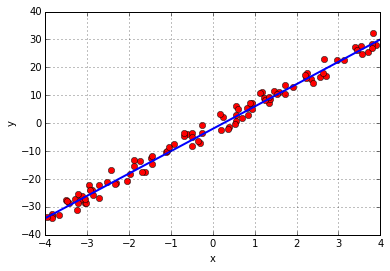

In [4]:
dataPlot('data.csv',w)

#Start Spark

In [5]:
import os
import sys
#Escape L for line numbers
spark_home = os.environ['SPARK_HOME'] = '/Users/liang/Downloads/spark-1.5.1-bin-hadoop2.6/'
spark_home = os.environ['SPARK_HOME'] = '/Users/jshanahan/Dropbox/Lectures-UC-Berkeley-ML-Class-2015/spark-1.5.0-bin-hadoop2.6/'
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.1
      /_/

Using Python version 2.7.10 (default, May 28 2015 17:04:42)
SparkContext available as sc, HiveContext available as sqlContext.


#Gradient descent (no regularization)

In [6]:
import numpy as np

def linearRegressionGD(data, wInitial=None, learningRate=0.05, iterations=50):
    featureLen = len(data.take(1)[0])-1
    n = data.count()
    if wInitial is None:  #start learning from a random vector
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:                 #start from provided vector
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)   #make available in memory as read-only to the executors (for mappers and reducers)
        gradient = data.map(lambda d: -2 * (d[0] - np.dot(wBroadcast.value, d[1:])) * np.array(d[1:])) \
                    .reduce(lambda a, b: a + b)
        w = w - learningRate * gradient/n
    return w

In [7]:
data = sc.textFile('data.csv').map(lambda line: [float(v) for v in line.split(',')]+[1.0]).cache()
linearRegressionGD(data)

array([ 7.98418741, -1.61969498])

##Plot w in iterations

In [26]:
def ierationsPlot(fileName, truew):
    x = [-4, 4]
    
    w = truew
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'b', label="True line", linewidth=4.0)
    
    data = sc.textFile(fileName).map(lambda line: [float(v) for v in line.split(',')]+[1.0]).cache()
    n = data.count()
    
    np.random.seed(400)
    w = np.random.normal(0,1,2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'r--', label="After 0 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 0 iterations: " + str(squared_error/n)
    

    
    w = linearRegressionGD(data, w, iterations=2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'g--', label="After 2 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 2 iterations: " + str(squared_error/n)
    
    w = linearRegressionGD(data, w, iterations=2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'm--', label="After 4 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 4 iterations: " + str(squared_error/n)
    
    w = linearRegressionGD(data, w, iterations=2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'y--', label="After 6 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 6 iterations: " + str(squared_error/n)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.show()

Mean Squared Error after 0 iterations: 464.394955261
Mean Squared Error after 2 iterations: 27.0859380611
Mean Squared Error after 4 iterations: 6.40859048434
Mean Squared Error after 6 iterations: 4.9932567759


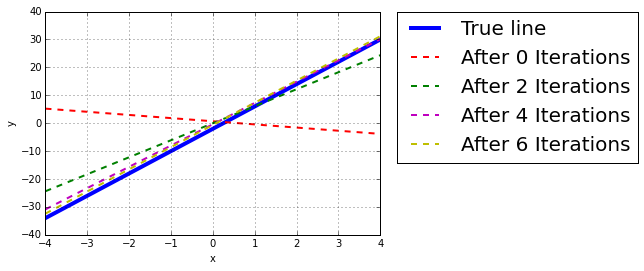

In [27]:
ierationsPlot('data.csv',w)

#Gradient descent (regularization)

In [12]:
def linearRegressionGDReg(data, wInitial=None, learningRate=0.05, iterations=50, regParam=0.01, regType=None):
    featureLen = len(data.take(1)[0])-1
    n = data.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)
        gradient = data.map(lambda d: -2 * (d[0] - np.dot(wBroadcast.value, d[1:])) * np.array(d[1:])) \
                    .reduce(lambda a, b: a + b)
        if regType == "Ridge":
            #Please fill in code
        elif regType == "Lasso":
            #Please fill in code
        else:
            wReg = np.zeros(w.shape[0])
        gradient = gradient + regParam * wReg  #gradient:  GD of Sqaured Error+ GD of regularized term 
        w = w - learningRate * gradient / n
    return w

##Ridge  Regression

In [13]:
np.random.seed(400)
linearRegressionGDReg(data, iterations=50, regParam=0.1, regType="Ridge")

array([ 7.98398871, -1.60876051])

##Lasso  Regression

In [14]:
np.random.seed(400)
linearRegressionGDReg(data, iterations=50, regParam=0.1, regType="Lasso")

array([ 7.98464511, -1.60861879])

#MLlib Linear Regression

http://spark.apache.org/docs/latest/mllib-linear-methods.html

In [17]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel

# Load and parse the data
def parsePoint(line):
    values = [float(x) for x in line.split(',')]
    return LabeledPoint(values[0], values[1:])

data = sc.textFile("data.csv")
parsedData = data.map(parsePoint)

# Build the model
model = LinearRegressionWithSGD.train(parsedData, intercept=True, iterations=50)
print model

model_ridge = LinearRegressionWithSGD.train(parsedData, regType="l2", regParam=0.1, intercept=True)
print model_ridge

model_lasso = LinearRegressionWithSGD.train(parsedData, regType="l1", regParam=0.1, intercept=True)
print model_lasso

(weights=[7.98393748404], intercept=-1.6187449131887346)
(weights=[7.84187615307], intercept=-1.4995150386072356)
(weights=[7.96888879755], intercept=-1.5288617888658909)
